In [1]:
import os
import pandas as pd

import sys
from datetime import datetime
sys.path.append('../../Scripts')

from preprocess_daily import DailyPreprocessor
dp = DailyPreprocessor()

from generate_signals import SignalGenerator
sg = SignalGenerator()
# sg.present_time = int(datetime(2024, 1, 5, 12, 5).timestamp())
print(sg.present_time)
print(datetime.fromtimestamp(sg.present_time))

# 1. 데이터 준비
sg.prepare_data()

1704416400
2024-01-05 10:00:00
1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.


# 단위테스트

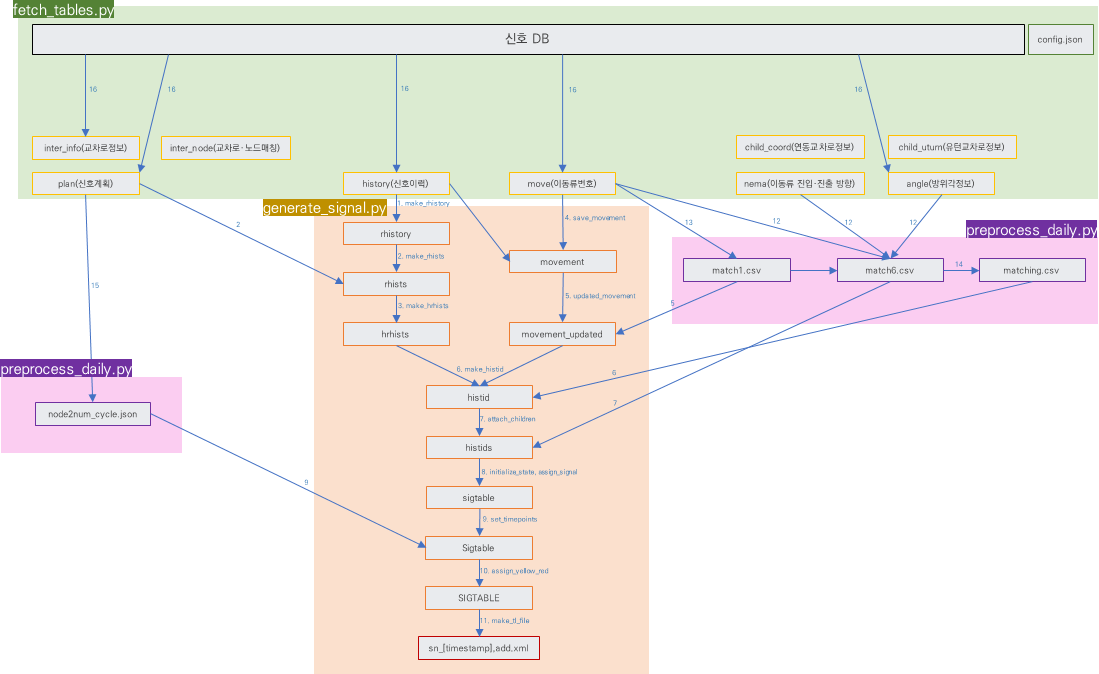

## 1. `make_rhistory`

### 1.1. 입력데이터
- 입력데이터
  - 프로젝트 진행시 입력데이터 : 신호이력에 대한 쿼리
  - 현재 입력데이터 : `history.csv`(하루치의 신호이력)
- 컬럼 : 교차로번호, 종료유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기, 옵셋

In [2]:
sg.history.head()

Unnamed: 0  inter_no    end_unix  dura_A1  dura_A2  dura_A3  dura_A4  \
0           0       206  1704380520       33       35       26       26   
1           1       202  1704380539       39      101        0        0   
2           2       178  1704380540       38       39       40       23   
3           3       201  1704380540       24       24       17       58   
4           4       177  1704380550       36       20       68       26   

   dura_A5  dura_A6  dura_A7  ...  dura_B1  dura_B2  dura_B3  dura_B4  \
0        0        0        0  ...       33       35       26       26   
1        0        0        0  ...       39      101        0        0   
2        0        0        0  ...       38       39       40       23   
3       17        0        0  ...       24       24       17       58   
4        0        0        0  ...       36       20       68       26   

   dura_B5  dura_B6  dura_B7  dura_B8  cycle  offset  
0        0        0        0        0    120      10  
1        0        0        0        0    140     103  
2        0        0        0        0    140      50  
3       17        0        0        0    140     133  
4        0        0        0        0    150      35  

[5 rows x 21 columns]

### 1.2 출력 데이터
- 출력데이터 : `rhistory`
- 컬럼 : 교차로번호, 시작유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기
- 설명 : 신호이력 로드, 슬라이싱(30분, 10분), 종료유닉스를 시작유닉스로 변경 등

In [3]:
sg.make_rhistory()
sg.rhistory.head()

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1811       210  1704414440       43       43       70       24        0   
1812       202  1704414490       46      114        0        0        0   
1813       178  1704414480       38       39       43       50        0   
1814       206  1704414510       45       53       26       26        0   
1815       201  1704414520       33       36       25       58       18   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1811        0        0        0       28       58       70       24        0   
1812        0        0        0       46      114        0        0        0   
1813        0        0        0       38       39       71       22        0   
1814        0        0        0       45       53       26       26        0   
1815        0        0        0       33       36       25       58       18   

      dura_B6  dura_B7  dura_B8  cycle  
1811        0        0        0    180  
1812        0        0        0    160  
1813        0        0        0    170  
1814        0        0        0    150  
1815        0        0        0    170

### 1.3 검증요건
1. 현재시점으로부터 `substractor`(30분) 동안의 신호이력 로드되었는가?
2. 현재시점 + `adder`(10분)에 한 주기가 신호 추가되었는가?
3. 종료유닉스가 시작유닉스로 잘 변환되었는가?
   - 이전 종료유닉스가 존재하지 않으면 현재 종료유닉스로부터 현시시간 합의 차로 한다.
   - 이전 종료유닉스가 존재하면 abs < 10인 경우 이전 종료유닉스로 하고, abs > 10인 경우 현시시간 합의 차로 한다.
4. 존재하지 않는 교차로에 대하여 한 주기 신호 추가되었는가?

### 1.4 검증

In [4]:
# 1 : 약 30분(1800초) 동안의 신호이력이 로드되었음
# 2 : 현재시점으로부터 약 10분(600초)이 경과한 시점까지의 신호이력이 로드되었음
print(sg.rhistory.start_unix.min())
print(sg.present_time, sg.present_time - sg.rhistory.start_unix.min())
print(sg.rhistory.start_unix.max(), sg.rhistory.start_unix.max() - sg.present_time)

1704414440
1704416400 1960
1704416820 420


In [5]:
# 3
inter_no = 176
h = sg.history[(sg.history.inter_no==inter_no) & (sg.history.end_unix <= sg.present_time) & (sg.history.end_unix > sg.present_time - sg.subtractor)]
rh = sg.rhistory[sg.rhistory.inter_no==inter_no]
display(h)
display(rh)
# 이전 종료유닉스가 존재하지 않을 경우 : index 1802
# print(h.loc[2183, [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]].sum() // 2)
# 이전 종료유닉스가 존재할 경우 : index 1810 ~ 

Unnamed: 0  inter_no    end_unix  dura_A1  dura_A2  dura_A3  dura_A4  \
1818        1818       176  1704414740       37      103       40        0   
1826        1826       176  1704414921       37      103       40        0   
1834        1834       176  1704415100       37      103       40        0   
1843        1843       176  1704415281       37      103       40        0   
1852        1852       176  1704415460       37      103       40        0   
1860        1860       176  1704415639       37      103       40        0   
1868        1868       176  1704415820       37      103       40        0   
1876        1876       176  1704415999       37      103       40        0   
1886        1886       176  1704416180       37      103       40        0   
1894        1894       176  1704416361       37      103       40        0   

      dura_A5  dura_A6  dura_A7  ...  dura_B1  dura_B2  dura_B3  dura_B4  \
1818        0        0        0  ...       37      103       40        0   
1826        0        0        0  ...       37      103       40        0   
1834        0        0        0  ...       37      103       40        0   
1843        0        0        0  ...       37      103       40        0   
1852        0        0        0  ...       37      103       40        0   
1860        0        0        0  ...       37      103       40        0   
1868        0        0        0  ...       37      103       40        0   
1876        0        0        0  ...       37      103       40        0   
1886        0        0        0  ...       37      103       40        0   
1894        0        0        0  ...       37      103       40        0   

      dura_B5  dura_B6  dura_B7  dura_B8  cycle  offset  
1818        0        0        0        0    180     169  
1826        0        0        0        0    180     169  
1834        0        0        0        0    180     169  
1843        0        0        0        0    180     169  
1852        0        0        0        0    180     169  
1860        0        0        0        0    180     169  
1868        0        0        0        0    180     169  
1876        0        0        0        0    180     169  
1886        0        0        0        0    180     169  
1894        0        0        0        0    180     169  

[10 rows x 21 columns]

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1818       176  1704414560       37      103       40        0        0   
1826       176  1704414740       37      103       40        0        0   
1834       176  1704414921       37      103       40        0        0   
1843       176  1704415100       37      103       40        0        0   
1852       176  1704415281       37      103       40        0        0   
1860       176  1704415460       37      103       40        0        0   
1868       176  1704415639       37      103       40        0        0   
1876       176  1704415820       37      103       40        0        0   
1886       176  1704415999       37      103       40        0        0   
1894       176  1704416180       37      103       40        0        0   
0          176  1704416820       37      103       40        0        0   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1818        0        0        0       37      103       40        0        0   
1826        0        0        0       37      103       40        0        0   
1834        0        0        0       37      103       40        0        0   
1843        0        0        0       37      103       40        0        0   
1852        0        0        0       37      103       40        0        0   
1860        0        0        0       37      103       40        0        0   
1868        0        0        0       37      103       40        0        0   
1876        0        0        0       37      103       40        0        0   
1886        0        0        0       37      103       40        0        0   
1894        0        0        0       37      103       40        0        0   
0           0        0        0       37      103       40        0        0   

      dura_B6  dura_B7  dura_B8  cycle  
1818        0        0        0    180  
1826        0        0        0    180  
1834        0        0        0    180  
1843        0        0        0    180  
1852        0        0        0    180  
1860        0        0        0    180  
1868        0        0        0    180  
1876        0        0        0    180  
1886        0        0        0    180  
1894        0        0        0    180  
0           0        0        0    180

In [6]:
# 4 : 현재시점에서는 검증할 수 없음. 하지만 이전에 검증하였음.
print(set(sg.history.inter_no))
print(set(sg.rhistory.inter_no))

{201, 202, 206, 175, 176, 177, 178, 210}
{201, 202, 206, 175, 176, 177, 178, 210}


## 2. `make_rhists`

### 2.1. 입력데이터
- 입력데이터 : `rhistory`
- 컬럼 : 교차로번호, 시작유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기

In [7]:
sg.rhistory.head()

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1811       210  1704414440       43       43       70       24        0   
1812       202  1704414490       46      114        0        0        0   
1813       178  1704414480       38       39       43       50        0   
1814       206  1704414510       45       53       26       26        0   
1815       201  1704414520       33       36       25       58       18   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1811        0        0        0       28       58       70       24        0   
1812        0        0        0       46      114        0        0        0   
1813        0        0        0       38       39       71       22        0   
1814        0        0        0       45       53       26       26        0   
1815        0        0        0       33       36       25       58       18   

      dura_B6  dura_B7  dura_B8  cycle  
1811        0        0        0    180  
1812        0        0        0    160  
1813        0        0        0    170  
1814        0        0        0    150  
1815        0        0        0    170

### 2.2. 출력데이터
- 출력 : `rhists`
- 컬럼 : 교차로번호, 시작유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기, 유닉스차이(`D_n`), 현시시간합(`S_n`)
- 설명 : `rhistory`에 대하여 참값프로세스 진행 후 현재시점 - `substractor//2`(15분)로 슬라이싱

In [8]:
sg.make_rhists()
sg.rhists.head()

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
6        210  1704415520       43       43       70       24        0   
7        210  1704415700       43       43       70       24        0   
8        210  1704415880       43       43       70       24        0   
9        210  1704416060       43       43       70       24        0   
10       210  1704416420       43       43       70       24        0   

    dura_A6  dura_A7  dura_A8  ...  dura_B4  dura_B5  dura_B6  dura_B7  \
6         0        0        0  ...       24        0        0        0   
7         0        0        0  ...       24        0        0        0   
8         0        0        0  ...       24        0        0        0   
9         0        0        0  ...       24        0        0        0   
10        0        0        0  ...       24        0        0        0   

    dura_B8  cycle    D_n    S_n  Unnamed: 0  offset  
6         0    180  900.0  900.0         NaN     NaN  
7         0    180  900.0  900.0         NaN     NaN  
8         0    180  900.0  900.0         NaN     NaN  
9         0    180  900.0  900.0         NaN     NaN  
10        0    180    NaN    NaN        30.0   137.0  

[5 rows x 23 columns]

### 2.3 검증요건
1. 결측치 처리
2. 이상치 처리 (삭제, 대체)
3. D_n, S_n의 계산 적정성 여부

### 2.4 검증

In [9]:
# 1. 마지막 시점에 결측 발생 -> 결측처리 이상없음
# 2. 결측 처리 후에 발생하는 이상치 -> 이상치처리 이상없음
### 3. D_n, S_n 계산에 이상있음. D_n과 S_n이 대부분의 경우에 다르므로, 대부분의 경우를 거짓값으로 판단한 채로 진행하고 있음.
# 다만, 이렇게 하여도 결과에는 영향은 없음. 단지 계산량이 많아져서 구동시간에 부하가 걸렸을 수 있음.
inter_no = 178
rhistory = sg.rhistory[sg.rhistory.inter_no==inter_no].copy()
rhistory['diff'] = rhistory['start_unix'].diff()
rhists = sg.rhists[sg.rhists.inter_no==inter_no].copy()
rhists['diff'] = rhists['start_unix'].diff()
display(rhistory)
display(rhists)

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1813       178  1704414480       38       39       43       50        0   
1822       178  1704414651       38       39       43       50        0   
1830       178  1704414820       38       39       43       50        0   
1838       178  1704414990       38       39       43       50        0   
1845       178  1704415160       38       39       43       50        0   
1853       178  1704415330       38       39       43       50        0   
1861       178  1704415500       38       39       43       50        0   
1869       178  1704415669       38       39       43       50        0   
1877       178  1704415840       38       39       43       50        0   
1885       178  1704416010       38       39       43       50        0   
1892       178  1704416180       38       39       43       50        0   
0          178  1704416820       38       39       43       50        0   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1813        0        0        0       38       39       71       22        0   
1822        0        0        0       38       39       71       22        0   
1830        0        0        0       38       39       71       22        0   
1838        0        0        0       38       39       71       22        0   
1845        0        0        0       38       39       71       22        0   
1853        0        0        0       38       39       71       22        0   
1861        0        0        0       38       39       71       22        0   
1869        0        0        0       38       39       71       22        0   
1877        0        0        0       38       39       71       22        0   
1885        0        0        0       38       39       71       22        0   
1892        0        0        0       38       39       71       22        0   
0           0        0        0       38       39       71       22        0   

      dura_B6  dura_B7  dura_B8  cycle   diff  
1813        0        0        0    170    NaN  
1822        0        0        0    170  171.0  
1830        0        0        0    170  169.0  
1838        0        0        0    170  170.0  
1845        0        0        0    170  170.0  
1853        0        0        0    170  170.0  
1861        0        0        0    170  170.0  
1869        0        0        0    170  169.0  
1877        0        0        0    170  171.0  
1885        0        0        0    170  170.0  
1892        0        0        0    170  170.0  
0           0        0        0    170  640.0

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
6        178  1704415500       38       39       43       50        0   
7        178  1704415669       37       38       42       49        0   
8        178  1704415840       38       39       43       50        0   
9        178  1704416010       38       39       43       50        0   
10       178  1704416180       38       39       43       50        0   
11       178  1704416350       29       29       32       38        0   
12       178  1704416690       38       39       43       50        0   
13       178  1704416820       29       29       32       38        0   

    dura_A6  dura_A7  dura_A8  ...  dura_B5  dura_B6  dura_B7  dura_B8  cycle  \
6         0        0        0  ...        0        0        0        0    170   
7         0        0        0  ...        0        0        0        0    166   
8         0        0        0  ...        0        0        0        0    170   
9         0        0        0  ...        0        0        0        0    170   
10        0        0        0  ...        0        0        0        0    170   
11        0        0        0  ...        0        0        0        0    128   
12        0        0        0  ...        0        0        0        0    170   
13        0        0        0  ...        0        0        0        0    128   

      D_n     S_n  Unnamed: 0  offset   diff  
6   900.0  1020.0         NaN     NaN    NaN  
7   900.0  1020.0         NaN     NaN  169.0  
8   900.0  1020.0         NaN     NaN  171.0  
9   900.0  1020.0         NaN     NaN  170.0  
10  900.0  1020.0         NaN     NaN  170.0  
11    NaN     NaN        14.0    80.0  170.0  
12    NaN     NaN        14.0    80.0  340.0  
13  900.0   510.0         NaN     NaN  130.0  

[8 rows x 24 columns]

## 3. `make_hrhists`

### 3.1. 입력데이터
- 입력데이터 : `rhists`
- 컬럼 : 교차로번호, 시작유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기, 유닉스차이(`D_n`), 현시시간합(`S_n`), 옵셋

In [10]:
sg.rhists.head()

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
6        210  1704415520       43       43       70       24        0   
7        210  1704415700       43       43       70       24        0   
8        210  1704415880       43       43       70       24        0   
9        210  1704416060       43       43       70       24        0   
10       210  1704416420       43       43       70       24        0   

    dura_A6  dura_A7  dura_A8  ...  dura_B4  dura_B5  dura_B6  dura_B7  \
6         0        0        0  ...       24        0        0        0   
7         0        0        0  ...       24        0        0        0   
8         0        0        0  ...       24        0        0        0   
9         0        0        0  ...       24        0        0        0   
10        0        0        0  ...       24        0        0        0   

    dura_B8  cycle    D_n    S_n  Unnamed: 0  offset  
6         0    180  900.0  900.0         NaN     NaN  
7         0    180  900.0  900.0         NaN     NaN  
8         0    180  900.0  900.0         NaN     NaN  
9         0    180  900.0  900.0         NaN     NaN  
10        0    180    NaN    NaN        30.0   137.0  

[5 rows x 23 columns]

### 3.2. 출력데이터
- 입력데이터 : `hrhists`
- 컬럼 : 교차로번호, 시작유닉스, A현시번호, B현시번호, 현시시간
- 설명 : `rhists`를 계층화

In [11]:
sg.make_hrhists()
sg.hrhists.head()

inter_no  start_unix  phas_A  phas_B  duration
0       210  1704415520       1       1        28
1       210  1704415520       1       2        15
2       210  1704415520       2       2        43
3       210  1704415520       3       3        70
4       210  1704415520       4       4        24

### 3.3 검증요건
- 계층화가 잘 이루어졌는가?

### 3.4 검증

In [12]:
### 계층화상의 오류 발견. 오버랩현시가 일어나는 경우 현시시간이 제대로 계산되지 않았음.
# durs_A = [getattr(row, f'dura_A{j}') for j in range(1, 9)]
# durs_B = [getattr(row, f'dura_A{j}') for j in range(1, 9)]
# 에서 durs_B의 코드 잘못됨. 수정완료.
inter_no = 175
start_unix = sg.rhists[sg.rhists.inter_no==inter_no].start_unix.min()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sg.rhists[(sg.rhists.inter_no==inter_no)&(sg.rhists.start_unix==start_unix)])
display(sg.hrhists[(sg.hrhists.inter_no==inter_no)&(sg.hrhists.start_unix==start_unix)])

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  dura_A6  \
6       175  1704415589       42       44       54       36        0        0   

   dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  dura_B6  \
6        0        0       42       44       32       58        0        0   

   dura_B7  dura_B8  cycle    D_n     S_n  Unnamed: 0  offset  
6        0        0    176  900.0  1080.0         NaN     NaN

inter_no  start_unix  phas_A  phas_B  duration
0       175  1704415589       1       1        42
1       175  1704415589       2       2        44
2       175  1704415589       3       3        32
3       175  1704415589       3       4        22
4       175  1704415589       4       4        36

## 4. `save_movement`

### 4.1. 입력데이터
- 입력데이터
  - 프로젝트 진행시 입력데이터 : 이동류정보에 대한 쿼리
  - 현재 입력데이터 : `movement_[timestamp].csv`, 현재시점으로부터 5분 이내의 이동류정보. 5초단위로 수집.
- 컬럼 : 교차로번호, A현시번호, B현시번호, A이동류번호, B이동류번호

In [13]:
display(pd.read_csv(os.path.join(sg.path_tables, 'move', f'move_{sg.present_time - 300}.csv')))
display(pd.read_csv(os.path.join(sg.path_tables, 'move', f'move_{sg.present_time}.csv')))

Unnamed: 0  inter_no  phas_A  phas_B  move_A  move_B
0           0       175       1       1       8       4
1           0       176       1       1       8       4
2           0       177       1       1       8       4
3           0       178       1       1       8       4
4           0       201       1       1       8       3
5           0       202       1       1       6       2
6           0       206       2       2      17      18
7           0       210       1       1       6      18

Unnamed: 0  inter_no  phas_A  phas_B  move_A  move_B
0           0       175       1       1       8       4
1           0       176       1       1       8       4
2           0       177       1       1       8       4
3           0       178       1       1       8       4
4           0       201       1       1       8       3
5           0       202       1       1       6       2
6           0       206       1       1       8       4
7           0       210       1       1       6      18

### 4.2 출력데이터
- 입력데이터 : `movement`
- 컬럼 : 교차로번호, A현시번호, B현시번호, A이동류번호, B이동류번호, 시작유닉스
- 설명 : 5분 동안의, 5초 간격의 60개 `movement_[timestamp]`를 모아서 pd.concat함. 이때, 신호이력에서 최근의 종료유닉스를 불러와서 `movement`의 시작유닉스로 삼음.

In [14]:
sg.make_movement()
sg.movement.head()

1704416100
      inter_no    end_unix
1874       175  1704415950
1876       176  1704415999
1875       177  1704415980
1877       178  1704416010
1879       201  1704416050
1881       202  1704416090
1878       206  1704416010
1880       210  1704416060
   inter_no  phas_A  phas_B  move_A  move_B  start_unix
0       175       1       1       8       4  1704415950
1       176       1       1       8       4  1704415999
2       177       1       1       8       4  1704415980
3       178       1       1       8       4  1704416010
4       201       1       1       8       3  1704416050
5       202       1       1       6       2  1704416090
6       206       2       2      17      18  1704416010
7       210       1       1       6      18  1704416060
8
   inter_no  phas_A  phas_B  move_A  move_B  start_unix
0       175       1       1       8       4  1704415950
1       176       1       1       8       4  1704415999
2       177       1       1       8       4  1704415980
3       178     

inter_no  phas_A  phas_B  move_A  move_B  start_unix
0       206       1       1       8       4  1704412820
1       206       2       2      17      18  1704412820
2       206       3       3       8       4  1704412820
3       206       4       4      17      18  1704412820
4       178       1       1       8       4  1704412880

### 4.3 검증요건
1. 특정한 시점의 `move`가 `movement`에 잘 반영되었는가?
2. 해당 시점의 `start_unix`가 `history`에서 잘 반영되었는가?
3. 현재시점 - `substractor//2`(15분)로 슬라이싱되었는가?

In [23]:
# 1 특정한 시점 = sg.present_time - 100
# 2
specific_time = sg.present_time - 100
move = display(pd.read_csv(os.path.join(sg.path_tables, 'move', f'move_{specific_time}.csv')))
display(move)
print(specific_time)
display(sg.history[(sg.history.end_unix>=specific_time-100)&(sg.history.end_unix<=specific_time+100)])
display(sg.movement[(sg.movement.start_unix>=specific_time-100)&(sg.movement.start_unix<=specific_time+100)])

Unnamed: 0  inter_no  phas_A  phas_B  move_A  move_B
0           0       175       1       1       8       4
1           0       176       2       2       8       3
2           0       177       2       2       7       3
3           0       178       4       4       6       1
4           0       201       4       4       6       1
5           0       202       2       2      17      18
6           0       206       1       1       8       4
7           0       210       2       2       5       2

None

1704419300


Unnamed: 0  inter_no    end_unix  dura_A1  dura_A2  dura_A3  dura_A4  \
2026        2026       178  1704419240       38       39       43       50   
2027        2027       175  1704419240       43       45       55       37   
2028        2028       176  1704419240       37      103       40        0   
2029        2029       201  1704419280       33       36       25       58   
2030        2030       202  1704419290       46      114        0        0   
2031        2031       210  1704419300       43       43       70       24   
2032        2032       206  1704419310       45       53       26       26   
2033        2033       177  1704419330       43       27       70       40   

      dura_A5  dura_A6  dura_A7  ...  dura_B1  dura_B2  dura_B3  dura_B4  \
2026        0        0        0  ...       38       39       71       22   
2027        0        0        0  ...       43       45       33       59   
2028        0        0        0  ...       37      103       40        0   
2029       18        0        0  ...       33       36       25       58   
2030        0        0        0  ...       46      114        0        0   
2031        0        0        0  ...       28       58       70       24   
2032        0        0        0  ...       45       53       26       26   
2033        0        0        0  ...       43       27       70       40   

      dura_B5  dura_B6  dura_B7  dura_B8  cycle  offset  
2026        0        0        0        0    170      80  
2027        0        0        0        0    180      28  
2028        0        0        0        0    180     169  
2029       18        0        0        0    170     134  
2030        0        0        0        0    160     103  
2031        0        0        0        0    180     137  
2032        0        0        0        0    150      17  
2033        0        0        0        0    180      41  

[8 rows x 21 columns]

inter_no  phas_A  phas_B  move_A  move_B  start_unix
639       175       1       1       8       4  1704419220
640       175       2       2       7       3  1704419220
641       175       3       3       6       1  1704419220
642       175       3       4       6       2  1704419220
643       175       4       4       5       2  1704419220
644       201       1       1       8       3  1704419230
645       201       2       2       5       2  1704419230
646       201       3       3       6       2  1704419230
647       201       4       4       6       1  1704419230
648       201       5       5       7       4  1704419230
649       176       1       1       8       4  1704419260
650       176       2       2       8       3  1704419260
651       176       3       3       5      18  1704419260
652       206       1       1       8       4  1704419270
653       206       2       2      17      18  1704419270
654       206       3       3       8       4  1704419270
655       206       4       4      17      18  1704419270
656       178       1       1       8       4  1704419340
657       178       2       2       7       3  1704419340
658       178       3       3       5       2  1704419340
659       202       1       1       6       2  1704419341
660       202       2       2      17      18  1704419341
661       210       1       1       6      18  1704419360
662       210       3       3       7       4  1704419360
663       210       4       4       8       3  1704419360
664       177       1       1       8       4  1704419370
665       177       4       4       5       1  1704419370

In [17]:
sg.make_rhists()
sg.rhists

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
8        176  1704414380       37      103       40        0        0   
9        176  1704414560       37      103       40        0        0   
10       176  1704414740       37      103       40        0        0   
11       176  1704414921       37      103       40        0        0   
12       176  1704415100       36      102       39        0        0   
..       ...         ...      ...      ...      ...      ...      ...   
10       201  1704415200       33       36       25       58       18   
11       201  1704415370       33       36       25       58       18   
12       201  1704415540       33       36       25       58       18   
13       201  1704415710       33       36       25       58       18   
14       201  1704415880       33       36       25       58       18   

    dura_A6  dura_A7  dura_A8  ...  dura_B4  dura_B5  dura_B6  dura_B7  \
8         0        0        0  ...        0        0        0        0   
9         0        0        0  ...        0        0        0        0   
10        0        0        0  ...        0        0        0        0   
11        0        0        0  ...        0        0        0        0   
12        0        0        0  ...        0        0        0        0   
..      ...      ...      ...  ...      ...      ...      ...      ...   
10        0        0        0  ...       58       18        0        0   
11        0        0        0  ...       58       18        0        0   
12        0        0        0  ...       58       18        0        0   
13        0        0        0  ...       58       18        0        0   
14        0        0        0  ...       58       18        0        0   

    dura_B8  cycle     D_n     S_n  Unnamed: 0  offset  
8         0    180  2400.0  1620.0         NaN     NaN  
9         0    180  2400.0  1800.0         NaN     NaN  
10        0    180  2400.0  1980.0         NaN     NaN  
11        0    180  2400.0  2160.0         NaN     NaN  
12        0    177  2400.0  2340.0         NaN     NaN  
..      ...    ...     ...     ...         ...     ...  
10        0    170  2400.0  1860.0         NaN     NaN  
11        0    170     NaN     NaN        18.0   134.0  
12        0    170     NaN     NaN        18.0   134.0  
13        0    170     NaN     NaN        18.0   134.0  
14        0    170     NaN     NaN        18.0   134.0  

[81 rows x 23 columns]